In [1]:
pip install datasets utils neptune omegaconf hydra-core matplotlib

In [4]:
import numpy as np
from datasets.iterable_dataset import IterableDataset
from torch.utils.data import DataLoader
from dataclasses import dataclass
from transformers import T5Tokenizer, BatchEncoding
from typing import List, Dict
import torch
import datasets
from transformers import Adafactor
import math
from torch.optim.lr_scheduler import (
            SequentialLR,
            LinearLR,
            LambdaLR,
        )
from collections import defaultdict

from accelerate.logging import get_logger
from omegaconf import OmegaConf, open_dict
import logging
import datasets
import transformers
import neptune
import os
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
def compute_input_and_target_lengths(inputs_length = 512, noise_density = 0.15, mean_noise_span_length =3):
    """This function is copy of `random_spans_helper <https://github.com/google-research/text-to-text-transfer-transformer/blob/84f8bcc14b5f2c03de51bd3587609ba8f6bbd1cd/t5/data/preprocessors.py#L2466>`__ .

    [Copied from https://github.com/huggingface/transformers/blob/main/examples/flax/language-modeling/run_t5_mlm_flax.py]
    Training parameters to avoid padding with random_spans_noise_mask.
    When training a model with random_spans_noise_mask, we would like to set the other
    training hyperparmeters in a way that avoids padding.
    This function helps us compute these hyperparameters.
    We assume that each noise span in the input is replaced by extra_tokens_per_span_inputs sentinel tokens,
    and each non-noise span in the targets is replaced by extra_tokens_per_span_targets sentinel tokens.
    This function tells us the required number of tokens in the raw example (for split_tokens())
    as well as the length of the encoded targets. Note that this function assumes
    the inputs and targets will have EOS appended and includes that in the reported length.

    Args:
        inputs_length: an integer - desired length of the tokenized inputs sequence
        noise_density: a float
        mean_noise_span_length: a float
    Returns:
        tokens_length: length of original text in tokens
        targets_length: an integer - length in tokens of encoded targets sequence
    """

    def _tokens_length_to_inputs_length_targets_length(tokens_length):
        num_noise_tokens = int(round(tokens_length * noise_density))
        num_nonnoise_tokens = tokens_length - num_noise_tokens
        num_noise_spans = int(round(num_noise_tokens / mean_noise_span_length))
        # inputs contain all nonnoise tokens, sentinels for all noise spans
        # and one EOS token.
        _input_length = num_nonnoise_tokens + num_noise_spans + 1
        _output_length = num_noise_tokens + num_noise_spans + 1
        return _input_length, _output_length

    tokens_length = inputs_length

    while _tokens_length_to_inputs_length_targets_length(tokens_length + 1)[0] <= inputs_length:
        tokens_length += 1

    inputs_length, targets_length = _tokens_length_to_inputs_length_targets_length(tokens_length)

    # minor hack to get the targets length to be equal to inputs length
    # which is more likely to have been set to a nice round number.
    if noise_density == 0.5 and targets_length > inputs_length:
        tokens_length -= 1
        targets_length -= 1
    return tokens_length, targets_length


def tokenize_function(examples, tokenizer, in_length):
    tokenizer_out = tokenizer(
        text=examples["text"],
        return_attention_mask=False,
    )

    input_ids = tokenizer_out["input_ids"]

    concatenated_ids = np.concatenate(input_ids)

    total_length = concatenated_ids.shape[0]
    total_length = (total_length // in_length) * in_length

    concatenated_ids = concatenated_ids[:total_length].reshape(-1, in_length)
    result = {"input_ids": concatenated_ids}

    return result

def process_dataset(dataset_splits, tokenizer):

    final_datasets = {}
    for split, dataset_split in dataset_splits.items():
        # We increase the input_length, because instead of masking tokens T5 replaces
        # masked spans with a single token, therefore to avoid padding we need to have
        # longer sequences at the start, before masking
        before_mask_input_length, _ = compute_input_and_target_lengths(
            inputs_length=512,
            noise_density=0.15,
            mean_noise_span_length=3,
        )
        dataset_split = dataset_split.map(
            tokenize_function,
            batch_size =10000,
            batched=True,
            fn_kwargs={
                'tokenizer': tokenizer,
                'in_length': before_mask_input_length,
            },
            remove_columns=['text'],
            writer_batch_size = 10000
        )
        dataset_split = dataset_split.to_iterable_dataset(num_shards = 128)

        dataset_split = dataset_split.shuffle(buffer_size=100_000, seed=43)
        final_datasets[split] = dataset_split

    return final_datasets

def get_data_collator(tokenizer):

    data_collator = DataCollatorForT5MLM(
        tokenizer=tokenizer,
        noise_density=0.15,
        mean_noise_span_length = 3,
        input_length=512,
        target_length=114,
        pad_token_id=0,
    )


    return data_collator

def get_dataloaders(tokenizer, data_splits):

    dataset = process_dataset(dataset_splits=data_splits, tokenizer=tokenizer)
    data_collator = get_data_collator(tokenizer=tokenizer)

    is_iterable = isinstance(dataset['train'], IterableDataset)

    dataloaders = {}

    for split in ['train', 'test']:
        batch_size = 16

        shuffle = (split == 'train') and not is_iterable


        dataloaders[split] = DataLoader(
            dataset[split],
            shuffle=shuffle,
            collate_fn=data_collator,
            batch_size=batch_size,
            pin_memory=True,
            num_workers=16,
            drop_last=False
        )



    return dataloaders['train'], dataloaders['test']

@dataclass
class DataCollatorForT5MLM:
    """
    [Copied from https://github.com/huggingface/transformers/blob/main/examples/flax/language-modeling/run_t5_mlm_flax.py]
    Data collator used for T5 span-masked language modeling.
    It is made sure that after masking the inputs are of length `data_args.max_seq_length` and targets are also of fixed length.
    For more information on how T5 span-masked language modeling works, one can take a look
    at the `official paper <https://arxiv.org/pdf/1910.10683.pdf>`__
    or the `official code for preprocessing <https://github.com/google-research/text-to-text-transfer-transformer/blob/master/t5/data/preprocessors.py>`__ .
    Args:
        tokenizer (:class:`~transformers.PreTrainedTokenizer` or :class:`~transformers.PreTrainedTokenizerFast`):
            The tokenizer used for encoding the data.
        noise_density (:obj:`float`):
            The probability with which to (randomly) mask tokens in the input.
        mean_noise_span_length (:obj:`float`):
            The average span length of the masked tokens.
        input_length (:obj:`int`):
            The expected input length after masking.
        target_length (:obj:`int`):
            The expected target length after masking.
        pad_token_id: (:obj:`int`):
            The pad token id of the model
        decoder_start_token_id: (:obj:`int):
            The decoder start token id of the model
    """
    def __init__(self, tokenizer: T5Tokenizer,
                 noise_density: float,
                 mean_noise_span_length: float,
                 input_length: int,
                 target_length: int,
                 pad_token_id: int):
        self.tokenizer = tokenizer
        self.noise_density = noise_density
        self.mean_noise_span_length = mean_noise_span_length
        self.input_length = input_length
        self.target_length = target_length
        self.pad_token_id = pad_token_id

    def __call__(self, examples: List[Dict[str, np.ndarray]]) -> BatchEncoding:
        # convert list to dict and tensorize input
        batch = BatchEncoding(
            {
                k: np.array([examples[i][k] for i in range(len(examples))])
                for k, v in examples[0].items()
            }
        )

        input_ids = batch["input_ids"]
        batch_size, expandend_input_length = input_ids.shape

        mask_indices = np.asarray(
            [
                self.random_spans_noise_mask(expandend_input_length)
                for i in range(batch_size)
            ]
        )
        labels_mask = ~mask_indices

        input_ids_sentinel = self.create_sentinel_ids(mask_indices.astype(np.int8))
        labels_sentinel = self.create_sentinel_ids(labels_mask.astype(np.int8))

        batch["input_ids"] = self.filter_input_ids(input_ids, input_ids_sentinel)
        batch["labels"] = self.filter_input_ids(input_ids, labels_sentinel)

        if batch["input_ids"].shape[-1] != self.input_length:
            raise ValueError(
                f"`input_ids` are incorrectly preprocessed. `input_ids` length is {batch['input_ids'].shape[-1]}, but"
                f" should be {self.input_length}."
            )

        if batch["labels"].shape[-1] != self.target_length:
            raise ValueError(
                f"`labels` are incorrectly preprocessed. `labels` length is {batch['labels'].shape[-1]}, but should be"
                f" {self.target_length}."
            )

        batch = {k: torch.from_numpy(v) for k, v in batch.items()}
        return batch

    def create_sentinel_ids(self, mask_indices):
        """
        Sentinel ids creation given the indices that should be masked.
        The start indices of each mask are replaced by the sentinel ids in increasing
        order. Consecutive mask indices to be deleted are replaced with `-1`.
        """
        start_indices = mask_indices - np.roll(mask_indices, 1, axis=-1) * mask_indices
        start_indices[:, 0] = mask_indices[:, 0]

        sentinel_ids = np.where(
            start_indices != 0, np.cumsum(start_indices, axis=-1), start_indices
        )
        sentinel_ids = np.where(
            sentinel_ids != 0, (len(self.tokenizer) - sentinel_ids), 0
        )
        sentinel_ids -= mask_indices - start_indices

        return sentinel_ids

    def filter_input_ids(self, input_ids, sentinel_ids):
        """
        Puts sentinel mask on `input_ids` and fuse consecutive mask tokens into a single mask token by deleting.
        This will reduce the sequence length from `expanded_inputs_length` to `input_length`.
        """
        batch_size = input_ids.shape[0]

        input_ids_full = np.where(sentinel_ids != 0, sentinel_ids, input_ids)
        # input_ids tokens and sentinel tokens are >= 0, tokens < 0 are
        # masked tokens coming after sentinel tokens and should be removed
        input_ids = input_ids_full[input_ids_full >= 0].reshape((batch_size, -1))
        input_ids = np.concatenate(
            [
                input_ids,
                np.full((batch_size, 1), self.tokenizer.eos_token_id, dtype=np.int32),
            ],
            axis=-1,
        )
        return input_ids

    def random_spans_noise_mask(self, length):
        """This function is copy of `random_spans_helper <https://github.com/google-research/text-to-text-transfer-transformer/blob/84f8bcc14b5f2c03de51bd3587609ba8f6bbd1cd/t5/data/preprocessors.py#L2682>`__ .

        Noise mask consisting of random spans of noise tokens.
        The number of noise tokens and the number of noise spans and non-noise spans
        are determined deterministically as follows:
        num_noise_tokens = round(length * noise_density)
        num_nonnoise_spans = num_noise_spans = round(num_noise_tokens / mean_noise_span_length)
        Spans alternate between non-noise and noise, beginning with non-noise.
        Subject to the above restrictions, all masks are equally likely.

        Args:
            length: an int32 scalar (length of the incoming token sequence)
            noise_density: a float - approximate density of output mask
            mean_noise_span_length: a number

        Returns:
            a boolean tensor with shape [length]
        """

        orig_length = length
        num_noise_tokens = int(np.round(length * self.noise_density))
        # avoid degeneracy by ensuring positive numbers of noise and nonnoise tokens.
        num_noise_tokens = min(max(num_noise_tokens, 1), length - 1)
        num_noise_spans = int(np.round(num_noise_tokens / self.mean_noise_span_length))

        # avoid degeneracy by ensuring positive number of noise spans
        num_noise_spans = max(num_noise_spans, 1)
        num_nonnoise_tokens = length - num_noise_tokens

        # pick the lengths of the noise spans and the non-noise spans
        def _random_segmentation(num_items, num_segments):
            """Partition a sequence of items randomly into non-empty segments.
            Args:
                num_items: an integer scalar > 0
                num_segments: an integer scalar in [1, num_items]
            Returns:
                a Tensor with shape [num_segments] containing positive integers that add
                up to num_items
            """
            mask_indices = np.arange(num_items - 1) < (num_segments - 1)
            np.random.shuffle(mask_indices)
            first_in_segment = np.pad(mask_indices, [[1, 0]])
            segment_id = np.cumsum(first_in_segment)
            # count length of sub segments assuming that list is sorted
            _, segment_length = np.unique(segment_id, return_counts=True)
            return segment_length

        noise_span_lengths = _random_segmentation(num_noise_tokens, num_noise_spans)
        nonnoise_span_lengths = _random_segmentation(
            num_nonnoise_tokens, num_noise_spans
        )

        interleaved_span_lengths = np.reshape(
            np.stack([nonnoise_span_lengths, noise_span_lengths], axis=1),
            [num_noise_spans * 2],
        )
        span_starts = np.cumsum(interleaved_span_lengths)[:-1]
        span_start_indicator = np.zeros((length,), dtype=np.int8)
        span_start_indicator[span_starts] = True
        span_num = np.cumsum(span_start_indicator)
        is_noise = np.equal(span_num % 2, 1)

        return is_noise[:orig_length]

def get_optimizer(model):
    no_decay = ["bias", "LayerNorm", "layernorm", "layer_norm", "ln"]

    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": 0.01,  # Add a non-zero weight decay for parameters that need it
        },
        {
            "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
            "weight_decay": 0.0,  # No weight decay for LayerNorm and bias
        },
    ]

    optimizer = Adafactor(
            optimizer_grouped_parameters,
            lr=2e-2,
            relative_step=False,
        )

    return optimizer

def train(model, train_dataloader, test_dataloader, accelerator, lr_scheduler,
          optimizer, total_train_step):
    model.train()
    current_train_step = 0
    batch_num = 0
    training_loss = []
    test_loss = []
    while current_train_step < total_train_step:
        print(f"Beginning epoch: {current_train_step + 1}")
        optimizer.zero_grad(set_to_none=True)

        for batch_id, batch in enumerate(train_dataloader, start=1):
            loss = forward(model, batch)
            accelerator.backward(loss)

            if batch_id % 50 == 0:
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad(set_to_none=True)
            if (batch_id + batch_num*current_train_step) % 100 ==0:
                maybe_save_checkpoint(accelerator, (batch_id + batch_num*current_train_step))
                print(f"The train loss after {(batch_id + batch_num*current_train_step)} batches is: {loss.item()}")
                training_loss.append(loss.item())
        test_avg_loss = maybe_eval_predict(model, test_dataloader)
        test_loss.append(test_avg_loss)
        print(f"Average test loss after epoch {current_train_step+1}: {test_avg_loss} \n")
        batch_num = batch_id
        current_train_step += 1
    return training_loss, test_loss

def maybe_eval_predict(model, dataloader):
    total_loss = 0
    num_batches = 0
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for batch in dataloader:
            loss = forward(model, batch)
            total_loss += loss.item()  # Accumulate loss
            num_batches += 1
    avg_loss = total_loss / num_batches if num_batches > 0 else float('inf')  # Calculate average loss
    model.train()  # Switch back to training mode
    return avg_loss

def forward(model, batch):
    outputs = model(**batch)
    loss = outputs.loss
    return loss


def maybe_save_checkpoint(accelerator, batch_id):
    output_dir = f'./checkpoints/checkpoint-{batch_id}'
    accelerator.save_state(output_dir=output_dir)


def get_lr_scheduler(optimizer):
    num_steps_optimizer1 = math.ceil(20_000 * 0.9)
    iters_left_for_optimizer2 = 20_000 - num_steps_optimizer1
    scheduler1 = LambdaLR(
        optimizer,
        lambda step: min(
            1e-2, 1.0 / math.sqrt(step)
        ) / 2e-2 if step else 1e-2 / 2e-2
    )
    scheduler2 = LinearLR(
        optimizer,
        start_factor=(
            min(1e-2, 1.0 / math.sqrt(num_steps_optimizer1)) / 2e-2
        ),
        end_factor=0,
        total_iters=iters_left_for_optimizer2,
        last_epoch=-1,
    )
    lr_scheduler = SequentialLR(
        optimizer,
        schedulers=[scheduler1, scheduler2],
        milestones=[num_steps_optimizer1]
    )

    return lr_scheduler






In [ ]:
import transformers
from transformers import T5ForConditionalGeneration, T5Config, T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments, Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import load_dataset, IterableDataset
import torch
from accelerate import Accelerator
import sys
# Add the directory containing your utils.py file to the Python path

import tensorboard

In [5]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:



dataset = load_dataset('json', data_files='/content/drive/MyDrive/Assignment 2/c4_dataset_10_mil.json')
config = T5Config.from_pretrained('t5-base')
model = T5ForConditionalGeneration(config)
tokenizer = T5Tokenizer.from_pretrained('T5-base',use_fast = True)

Generating train split: 0 examples [00:00, ? examples/s]

Loading dataset shards:   0%|          | 0/45 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
from torch.utils.data import IterableDataset

# Split dataset and remove unwanted columns
data_splits = dataset['train'].select(range(200_000)).train_test_split(test_size=0.2, shuffle=True).remove_columns(['timestamp', 'url'])

# Check the number of rows
print(f"Train set size: {data_splits['train'].num_rows}")
print(f"Test set size: {data_splits['test'].num_rows}")

# Check if train split is an IterableDataset
print(isinstance(data_splits['train'], IterableDataset))  # This will likely return False


Train set size: 160000
Test set size: 40000
False


In [ ]:
before_mask_input_length, target_length = compute_input_and_target_lengths(
            inputs_length=512,
            noise_density=0.15,
            mean_noise_span_length=3,
        )
data_collator = DataCollatorForT5MLM(tokenizer=tokenizer, noise_density= 0.15, mean_noise_span_length= 3, input_length= 512, target_length= target_length, pad_token_id=0)
train_dataloader, test_dataloader = get_dataloaders(tokenizer=tokenizer, data_splits=data_splits)


Map:   0%|          | 0/160000 [00:00<?, ? examples/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:

optimizer = get_optimizer(model)
lr_scheduler = get_lr_scheduler(optimizer)
accelerate = Accelerator()
optimizer, lr_scheduler, model, train_dataloader, test_dataloader = accelerate.prepare(optimizer, lr_scheduler, model, train_dataloader, test_dataloader)
training_loss, test_loss = train(model = model, train_dataloader= train_dataloader, test_dataloader= test_dataloader, accelerator=accelerate, lr_scheduler= lr_scheduler, optimizer= optimizer, total_train_step= 3)




Beginning epoch: 1


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


The train loss after 100 batches is: 9.365729331970215


The train loss after 200 batches is: 9.19832706451416


The train loss after 300 batches is: 8.602438926696777


The train loss after 400 batches is: 7.608885765075684


The train loss after 500 batches is: 7.407654762268066


The train loss after 600 batches is: 7.4249749183654785


The train loss after 700 batches is: 7.038185119628906


The train loss after 800 batches is: 6.959164619445801


The train loss after 900 batches is: 6.989784240722656


The train loss after 1000 batches is: 6.847598075866699


The train loss after 1100 batches is: 7.049921989440918


The train loss after 1200 batches is: 7.026839733123779


The train loss after 1300 batches is: 6.991694927215576


The train loss after 1400 batches is: 6.862361907958984


The train loss after 1500 batches is: 6.893239974975586


The train loss after 1600 batches is: 6.699061870574951


The train loss after 1700 batches is: 6.910085201263428


The train loss after 1800 batches is: 6.777299404144287


The train loss after 1900 batches is: 6.692427158355713


The train loss after 2000 batches is: 6.687772750854492


The train loss after 2100 batches is: 6.687133312225342


The train loss after 2200 batches is: 6.656919479370117


The train loss after 2300 batches is: 6.784564018249512


The train loss after 2400 batches is: 6.610323905944824


The train loss after 2500 batches is: 6.55567741394043


The train loss after 2600 batches is: 6.485971450805664


The train loss after 2700 batches is: 6.740026950836182


The train loss after 2800 batches is: 6.775608539581299


The train loss after 2900 batches is: 6.469042778015137


The train loss after 3000 batches is: 6.472172260284424


The train loss after 3100 batches is: 6.437539100646973


The train loss after 3200 batches is: 6.478540420532227


The train loss after 3300 batches is: 6.414333820343018


The train loss after 3400 batches is: 6.547355651855469


The train loss after 3500 batches is: 6.361141204833984


The train loss after 3600 batches is: 6.3595685958862305


The train loss after 3700 batches is: 6.361952781677246


The train loss after 3800 batches is: 6.440568447113037


The train loss after 3900 batches is: 6.563980579376221


The train loss after 4000 batches is: 6.595272064208984


The train loss after 4100 batches is: 6.581563472747803


The train loss after 4200 batches is: 6.533376693725586


The train loss after 4300 batches is: 6.365448951721191


The train loss after 4400 batches is: 6.159099578857422


The train loss after 4500 batches is: 6.348639965057373


The train loss after 4600 batches is: 6.16521692276001


The train loss after 4700 batches is: 6.321365833282471


The train loss after 4800 batches is: 6.069609642028809


The train loss after 4900 batches is: 6.282151222229004


The train loss after 5000 batches is: 6.084079742431641


The train loss after 5100 batches is: 6.421392917633057


The train loss after 5200 batches is: 6.050745487213135


The train loss after 5300 batches is: 6.273314952850342


The train loss after 5400 batches is: 6.122916221618652


The train loss after 5500 batches is: 5.974319934844971


The train loss after 5600 batches is: 6.0796027183532715


The train loss after 5700 batches is: 6.203830242156982


The train loss after 5800 batches is: 6.118112564086914


The train loss after 5900 batches is: 6.249223709106445


The train loss after 6000 batches is: 5.988945484161377


The train loss after 6100 batches is: 6.2149128913879395


The train loss after 6200 batches is: 6.14533805847168


The train loss after 6300 batches is: 5.990443229675293


The train loss after 6400 batches is: 6.103311061859131


The train loss after 6500 batches is: 5.998871326446533


The train loss after 6600 batches is: 6.131036281585693


The train loss after 6700 batches is: 6.079791069030762


The train loss after 6800 batches is: 6.0457682609558105


The train loss after 6900 batches is: 6.08007287979126


The train loss after 7000 batches is: 5.9364495277404785


The train loss after 7100 batches is: 6.069282054901123


The train loss after 7200 batches is: 5.971954822540283


The train loss after 7300 batches is: 6.01610803604126


The train loss after 7400 batches is: 6.00242280960083


The train loss after 7500 batches is: 5.9824934005737305


The train loss after 7600 batches is: 5.940808296203613


The train loss after 7700 batches is: 6.128057479858398


The train loss after 7800 batches is: 6.003981590270996


The train loss after 7900 batches is: 6.120095729827881


The train loss after 8000 batches is: 5.94514274597168


The train loss after 8100 batches is: 5.975055694580078


The train loss after 8200 batches is: 6.114561557769775


The train loss after 8300 batches is: 6.009870529174805


The train loss after 8400 batches is: 6.011696815490723


The train loss after 8500 batches is: 6.004977226257324


The train loss after 8600 batches is: 6.0378193855285645


The train loss after 8700 batches is: 5.991050720214844


The train loss after 8800 batches is: 5.919557094573975


The train loss after 8900 batches is: 5.810869216918945
Average test loss after epoch 1: 5.849240145605544 

Beginning epoch: 2


The train loss after 9000 batches is: 5.884807586669922


The train loss after 9100 batches is: 5.94105863571167


The train loss after 9200 batches is: 5.842581272125244


The train loss after 9300 batches is: 5.948533535003662


The train loss after 9400 batches is: 5.783087253570557


The train loss after 9500 batches is: 5.929996490478516


The train loss after 9600 batches is: 5.756640434265137


The train loss after 9700 batches is: 6.071109294891357


The train loss after 9800 batches is: 5.959255695343018


The train loss after 9900 batches is: 5.920016765594482


The train loss after 10000 batches is: 5.841368198394775


The train loss after 10100 batches is: 5.833892822265625


The train loss after 10200 batches is: 5.856712341308594


The train loss after 10300 batches is: 5.703997611999512


The train loss after 10400 batches is: 5.9564433097839355


The train loss after 10500 batches is: 6.063764572143555


The train loss after 10600 batches is: 5.673460006713867


The train loss after 10700 batches is: 5.908866882324219


The train loss after 10800 batches is: 5.699141979217529


The train loss after 10900 batches is: 5.813187599182129


The train loss after 11000 batches is: 5.932260513305664


The train loss after 11100 batches is: 5.759991645812988


The train loss after 11200 batches is: 5.842973709106445


The train loss after 11300 batches is: 5.7938337326049805


The train loss after 11400 batches is: 5.896027088165283


The train loss after 11500 batches is: 5.764038562774658


The train loss after 11600 batches is: 5.749673366546631


The train loss after 11700 batches is: 5.731879711151123


The train loss after 11800 batches is: 5.869507789611816


The train loss after 11900 batches is: 5.742262840270996


The train loss after 12000 batches is: 5.779548168182373


The train loss after 12100 batches is: 5.722441673278809


The train loss after 12200 batches is: 5.950199127197266


The train loss after 12300 batches is: 5.7678914070129395


The train loss after 12400 batches is: 5.724435806274414


The train loss after 12500 batches is: 5.6446919441223145


The train loss after 12600 batches is: 5.796103000640869


The train loss after 12700 batches is: 5.6048479080200195


The train loss after 12800 batches is: 5.633297920227051


The train loss after 12900 batches is: 5.853075981140137


The train loss after 13000 batches is: 5.655407428741455


The train loss after 13100 batches is: 5.645417213439941


The train loss after 13200 batches is: 5.497647285461426


The train loss after 13300 batches is: 5.7042765617370605


The train loss after 13400 batches is: 5.612895965576172


The train loss after 13500 batches is: 5.719557762145996


The train loss after 13600 batches is: 5.700380325317383


The train loss after 13700 batches is: 5.678417205810547


The train loss after 13800 batches is: 5.645920276641846


The train loss after 13900 batches is: 5.540779113769531


The train loss after 14000 batches is: 5.720761299133301


The train loss after 14100 batches is: 5.883863925933838


The train loss after 14200 batches is: 5.712005138397217


The train loss after 14300 batches is: 5.723095417022705


The train loss after 14400 batches is: 5.680659770965576


The train loss after 14500 batches is: 5.601518154144287


The train loss after 14600 batches is: 5.591604232788086


The train loss after 14700 batches is: 5.878881931304932


The train loss after 14800 batches is: 5.720902442932129


The train loss after 14900 batches is: 5.55402135848999


The train loss after 15000 batches is: 5.582785606384277


The train loss after 15100 batches is: 5.577512741088867


The train loss after 15200 batches is: 5.82511568069458


The train loss after 15300 batches is: 5.594791412353516


The train loss after 15400 batches is: 5.612185478210449


The train loss after 15500 batches is: 5.805999279022217


The train loss after 15600 batches is: 5.743765830993652


The train loss after 15700 batches is: 5.796547889709473


The train loss after 15800 batches is: 5.560815811157227


The train loss after 15900 batches is: 5.687946319580078


The train loss after 16000 batches is: 5.612951755523682


The train loss after 16100 batches is: 5.550206184387207


The train loss after 16200 batches is: 5.6615729331970215


The train loss after 16300 batches is: 5.579744338989258


The train loss after 16400 batches is: 5.588640213012695


The train loss after 16500 batches is: 5.69268798828125


The train loss after 16600 batches is: 5.602654933929443


The train loss after 16700 batches is: 5.533722877502441


The train loss after 16800 batches is: 5.514621257781982


The train loss after 16900 batches is: 5.57498025894165


The train loss after 17000 batches is: 5.395508289337158


The train loss after 17100 batches is: 5.540371894836426


The train loss after 17200 batches is: 5.685665607452393


The train loss after 17300 batches is: 5.684194087982178


The train loss after 17400 batches is: 5.66119384765625


The train loss after 17500 batches is: 5.675906658172607


The train loss after 17600 batches is: 5.65369176864624


The train loss after 17700 batches is: 5.6656999588012695


The train loss after 17800 batches is: 5.42915678024292
Average test loss after epoch 2: 5.488414653401444 

Beginning epoch: 3


The train loss after 17900 batches is: 5.722805500030518


The train loss after 18000 batches is: 5.599557876586914


The train loss after 18100 batches is: 5.522079944610596


The train loss after 18200 batches is: 5.71864652633667


The train loss after 18300 batches is: 5.536969184875488


The train loss after 18400 batches is: 5.582062244415283


The train loss after 18500 batches is: 5.469666004180908


The train loss after 18600 batches is: 5.54634428024292


The train loss after 18700 batches is: 5.707618713378906


The train loss after 18800 batches is: 5.40160608291626


The train loss after 18900 batches is: 5.744106769561768


The train loss after 19000 batches is: 5.336950302124023


The train loss after 19100 batches is: 5.667201519012451


The train loss after 19200 batches is: 5.636989116668701


The train loss after 19300 batches is: 5.513853073120117


The train loss after 19400 batches is: 5.50349760055542


The train loss after 19500 batches is: 5.438122272491455


The train loss after 19600 batches is: 5.572107315063477


The train loss after 19700 batches is: 5.565700054168701


The train loss after 19800 batches is: 5.497678756713867


The train loss after 19900 batches is: 5.611058235168457


The train loss after 20000 batches is: 5.547273635864258


The train loss after 20100 batches is: 5.5130934715271


The train loss after 20200 batches is: 5.529122829437256


The train loss after 20300 batches is: 5.684083938598633


The train loss after 20400 batches is: 5.529684543609619


The train loss after 20500 batches is: 5.527307987213135


The train loss after 20600 batches is: 5.5636677742004395


The train loss after 20700 batches is: 5.419538974761963


The train loss after 20800 batches is: 5.417291641235352


The train loss after 20900 batches is: 5.464641571044922


The train loss after 21000 batches is: 5.543519973754883


The train loss after 21100 batches is: 5.520951271057129


The train loss after 21200 batches is: 5.459095001220703


The train loss after 21300 batches is: 5.459914207458496


The train loss after 21400 batches is: 5.451303005218506


The train loss after 21500 batches is: 5.623291969299316


The train loss after 21600 batches is: 5.642099380493164


The train loss after 21700 batches is: 5.478429317474365


The train loss after 21800 batches is: 5.499906539916992


The train loss after 21900 batches is: 5.465245246887207


The train loss after 22000 batches is: 5.547756195068359


The train loss after 22100 batches is: 5.386806488037109


The train loss after 22200 batches is: 5.700200080871582


The train loss after 22300 batches is: 5.440499782562256


The train loss after 22400 batches is: 5.4628424644470215


The train loss after 22500 batches is: 5.32872200012207


The train loss after 22600 batches is: 5.306259632110596


The train loss after 22700 batches is: 5.430745601654053


The train loss after 22800 batches is: 5.50385856628418


The train loss after 22900 batches is: 5.542825698852539


The train loss after 23000 batches is: 5.427102088928223


The train loss after 23100 batches is: 5.438210964202881


The train loss after 23200 batches is: 5.361327171325684


The train loss after 23300 batches is: 5.504112720489502


The train loss after 23400 batches is: 5.460913181304932


The train loss after 23500 batches is: 5.414729595184326


The train loss after 23600 batches is: 5.22133207321167


The train loss after 23700 batches is: 5.50567102432251


The train loss after 23800 batches is: 5.376563549041748


The train loss after 23900 batches is: 5.510520935058594


The train loss after 24000 batches is: 5.354579448699951


The train loss after 24100 batches is: 5.287727355957031


The train loss after 24200 batches is: 5.463893413543701


The train loss after 24300 batches is: 5.472977161407471


The train loss after 24400 batches is: 5.503170967102051


The train loss after 24500 batches is: 5.3086628913879395


The train loss after 24600 batches is: 5.362423896789551


The train loss after 24700 batches is: 5.442354202270508


The train loss after 24800 batches is: 5.5195393562316895


The train loss after 24900 batches is: 5.199518203735352


The train loss after 25000 batches is: 5.35425329208374


The train loss after 25100 batches is: 5.22666597366333


The train loss after 25200 batches is: 5.295161724090576


The train loss after 25300 batches is: 5.441407203674316


The train loss after 25400 batches is: 5.418078899383545


The train loss after 25500 batches is: 5.427759170532227


The train loss after 25600 batches is: 5.394174575805664


The train loss after 25700 batches is: 5.368099689483643


The train loss after 25800 batches is: 5.466054439544678


The train loss after 25900 batches is: 5.330499172210693


The train loss after 26000 batches is: 5.3945536613464355


The train loss after 26100 batches is: 5.432321548461914


The train loss after 26200 batches is: 5.581724166870117


The train loss after 26300 batches is: 5.473223686218262


The train loss after 26400 batches is: 5.386104583740234


The train loss after 26500 batches is: 5.2959771156311035


The train loss after 26600 batches is: 5.365622043609619


The train loss after 26700 batches is: 5.341323375701904
Average test loss after epoch 3: 5.283358494656674 



In [ ]:
print(training_loss)

[9.365729331970215, 9.19832706451416, 8.602438926696777, 7.608885765075684, 7.407654762268066, 7.4249749183654785, 7.038185119628906, 6.959164619445801, 6.989784240722656, 6.847598075866699, 7.049921989440918, 7.026839733123779, 6.991694927215576, 6.862361907958984, 6.893239974975586, 6.699061870574951, 6.910085201263428, 6.777299404144287, 6.692427158355713, 6.687772750854492, 6.687133312225342, 6.656919479370117, 6.784564018249512, 6.610323905944824, 6.55567741394043, 6.485971450805664, 6.740026950836182, 6.775608539581299, 6.469042778015137, 6.472172260284424, 6.437539100646973, 6.478540420532227, 6.414333820343018, 6.547355651855469, 6.361141204833984, 6.3595685958862305, 6.361952781677246, 6.440568447113037, 6.563980579376221, 6.595272064208984, 6.581563472747803, 6.533376693725586, 6.365448951721191, 6.159099578857422, 6.348639965057373, 6.16521692276001, 6.321365833282471, 6.069609642028809, 6.282151222229004, 6.084079742431641, 6.421392917633057, 6.050745487213135, 6.2733149528

In [6]:
training_loss = [9.365729331970215, 9.19832706451416, 8.602438926696777, 7.608885765075684, 7.407654762268066, 7.4249749183654785, 7.038185119628906, 6.959164619445801, 6.989784240722656, 6.847598075866699, 7.049921989440918, 7.026839733123779, 6.991694927215576, 6.862361907958984, 6.893239974975586, 6.699061870574951, 6.910085201263428, 6.777299404144287, 6.692427158355713, 6.687772750854492, 6.687133312225342, 6.656919479370117, 6.784564018249512, 6.610323905944824, 6.55567741394043, 6.485971450805664, 6.740026950836182, 6.775608539581299, 6.469042778015137, 6.472172260284424, 6.437539100646973, 6.478540420532227, 6.414333820343018, 6.547355651855469, 6.361141204833984, 6.3595685958862305, 6.361952781677246, 6.440568447113037, 6.563980579376221, 6.595272064208984, 6.581563472747803, 6.533376693725586, 6.365448951721191, 6.159099578857422, 6.348639965057373, 6.16521692276001, 6.321365833282471, 6.069609642028809, 6.282151222229004, 6.084079742431641, 6.421392917633057, 6.050745487213135, 6.273314952850342, 6.122916221618652, 5.974319934844971, 6.0796027183532715, 6.203830242156982, 6.118112564086914, 6.249223709106445, 5.988945484161377, 6.2149128913879395, 6.14533805847168, 5.990443229675293, 6.103311061859131, 5.998871326446533, 6.131036281585693, 6.079791069030762, 6.0457682609558105, 6.08007287979126, 5.9364495277404785, 6.069282054901123, 5.971954822540283, 6.01610803604126, 6.00242280960083, 5.9824934005737305, 5.940808296203613, 6.128057479858398, 6.003981590270996, 6.120095729827881, 5.94514274597168, 5.975055694580078, 6.114561557769775, 6.009870529174805, 6.011696815490723, 6.004977226257324, 6.0378193855285645, 5.991050720214844, 5.919557094573975, 5.810869216918945, 5.884807586669922, 5.94105863571167, 5.842581272125244, 5.948533535003662, 5.783087253570557, 5.929996490478516, 5.756640434265137, 6.071109294891357, 5.959255695343018, 5.920016765594482, 5.841368198394775, 5.833892822265625, 5.856712341308594, 5.703997611999512, 5.9564433097839355, 6.063764572143555, 5.673460006713867, 5.908866882324219, 5.699141979217529, 5.813187599182129, 5.932260513305664, 5.759991645812988, 5.842973709106445, 5.7938337326049805, 5.896027088165283, 5.764038562774658, 5.749673366546631, 5.731879711151123, 5.869507789611816, 5.742262840270996, 5.779548168182373, 5.722441673278809, 5.950199127197266, 5.7678914070129395, 5.724435806274414, 5.6446919441223145, 5.796103000640869, 5.6048479080200195, 5.633297920227051, 5.853075981140137, 5.655407428741455, 5.645417213439941, 5.497647285461426, 5.7042765617370605, 5.612895965576172, 5.719557762145996, 5.700380325317383, 5.678417205810547, 5.645920276641846, 5.540779113769531, 5.720761299133301, 5.883863925933838, 5.712005138397217, 5.723095417022705, 5.680659770965576, 5.601518154144287, 5.591604232788086, 5.878881931304932, 5.720902442932129, 5.55402135848999, 5.582785606384277, 5.577512741088867, 5.82511568069458, 5.594791412353516, 5.612185478210449, 5.805999279022217, 5.743765830993652, 5.796547889709473, 5.560815811157227, 5.687946319580078, 5.612951755523682, 5.550206184387207, 5.6615729331970215, 5.579744338989258, 5.588640213012695, 5.69268798828125, 5.602654933929443, 5.533722877502441, 5.514621257781982, 5.57498025894165, 5.395508289337158, 5.540371894836426, 5.685665607452393, 5.684194087982178, 5.66119384765625, 5.675906658172607, 5.65369176864624, 5.6656999588012695, 5.42915678024292, 5.722805500030518, 5.599557876586914, 5.522079944610596, 5.71864652633667, 5.536969184875488, 5.582062244415283, 5.469666004180908, 5.54634428024292, 5.707618713378906, 5.40160608291626, 5.744106769561768, 5.336950302124023, 5.667201519012451, 5.636989116668701, 5.513853073120117, 5.50349760055542, 5.438122272491455, 5.572107315063477, 5.565700054168701, 5.497678756713867, 5.611058235168457, 5.547273635864258, 5.5130934715271, 5.529122829437256, 5.684083938598633, 5.529684543609619, 5.527307987213135, 5.5636677742004395, 5.419538974761963, 5.417291641235352, 5.464641571044922, 5.543519973754883, 5.520951271057129, 5.459095001220703, 5.459914207458496, 5.451303005218506, 5.623291969299316, 5.642099380493164, 5.478429317474365, 5.499906539916992, 5.465245246887207, 5.547756195068359, 5.386806488037109, 5.700200080871582, 5.440499782562256, 5.4628424644470215, 5.32872200012207, 5.306259632110596, 5.430745601654053, 5.50385856628418, 5.542825698852539, 5.427102088928223, 5.438210964202881, 5.361327171325684, 5.504112720489502, 5.460913181304932, 5.414729595184326, 5.22133207321167, 5.50567102432251, 5.376563549041748, 5.510520935058594, 5.354579448699951, 5.287727355957031, 5.463893413543701, 5.472977161407471, 5.503170967102051, 5.3086628913879395, 5.362423896789551, 5.442354202270508, 5.5195393562316895, 5.199518203735352, 5.35425329208374, 5.22666597366333, 5.295161724090576, 5.441407203674316, 5.418078899383545, 5.427759170532227, 5.394174575805664, 5.368099689483643, 5.466054439544678, 5.330499172210693, 5.3945536613464355, 5.432321548461914, 5.581724166870117, 5.473223686218262, 5.386104583740234, 5.2959771156311035, 5.365622043609619, 5.341323375701904]




In [7]:
test_loss = [5.849240145605544, 5.488414653401444, 5.283358494656674]

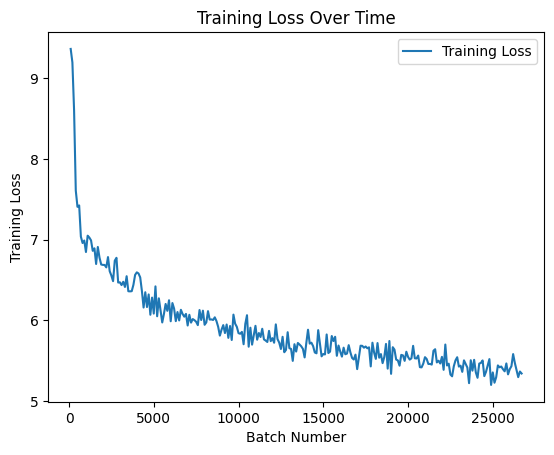

In [9]:
from matplotlib import pyplot as plt
import numpy as np

plt.plot(np.arange(100, 26800, 100), training_loss, label='Training Loss')
plt.xlabel('Batch Number')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()


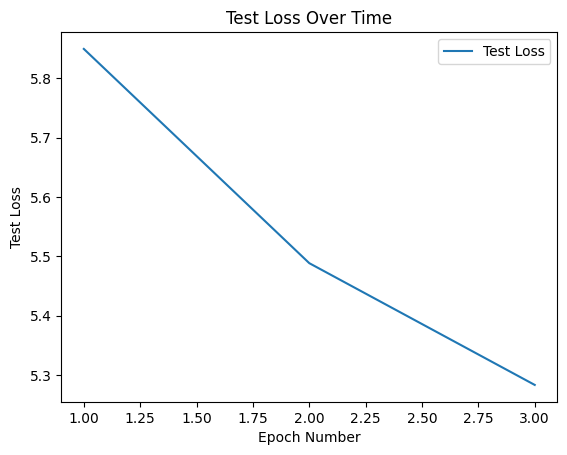

In [10]:
from matplotlib import pyplot as plt
import numpy as np

plt.plot(np.arange(1, 4, 1), test_loss, label='Test Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Test Loss')
plt.title('Test Loss Over Time')
plt.legend()
plt.show()